This notebook 'clips' the spatial domain of the Doppio model to a shapefile. 
The purpose of this is to restrict to the model domain to a specific area of focus.

Before you continue, be sure to insert the file path of your shapefile

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xroms

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray 

import geopandas as gpd
from shapely.geometry import Point


from matplotlib.colors import ListedColormap

import warnings

warnings.filterwarnings("ignore")

In [ ]:
## Load in the DOPPIO dataset--this is the Daily Avg from 2007-2024
url = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/DopAnV3R3-ini2007_da/avg"
ds = xr.open_dataset(url,chunks={"ocean_time": 1},  decode_times=True) #
doppio, xgrid = xroms.roms_dataset(ds, include_3D_metrics=True)

In [ ]:
## Load in the shapefile you want to use to clip the model domain
fname ='INSERT SHAPEFILE PATHNAME HERE'
shapefile = gpd.read_file(fname) 

In [ ]:
## Create a varibale for just the lat and lon values
lat = doppio['lat_rho'].values  
lon = doppio['lon_rho'].values 

# Flatten and create mask
lat_flat = lat.ravel()
lon_flat = lon.ravel()

polygon = shapefile.geometry.unary_union ## Create a single polygon from the shapefile

points = [Point(lon, lat) for lon, lat in zip(lon_flat, lat_flat)]
mask_flat = np.array([polygon.contains(pt) for pt in points])
mask_2d = mask_flat.reshape(lat.shape)

In [10]:
## Apply the mask to the dataset 
for var in ds.data_vars:
    if set(['eta_rho', 'xi_rho']).issubset(ds[var].dims):
        ds[var] = ds[var].where(mask_2d)

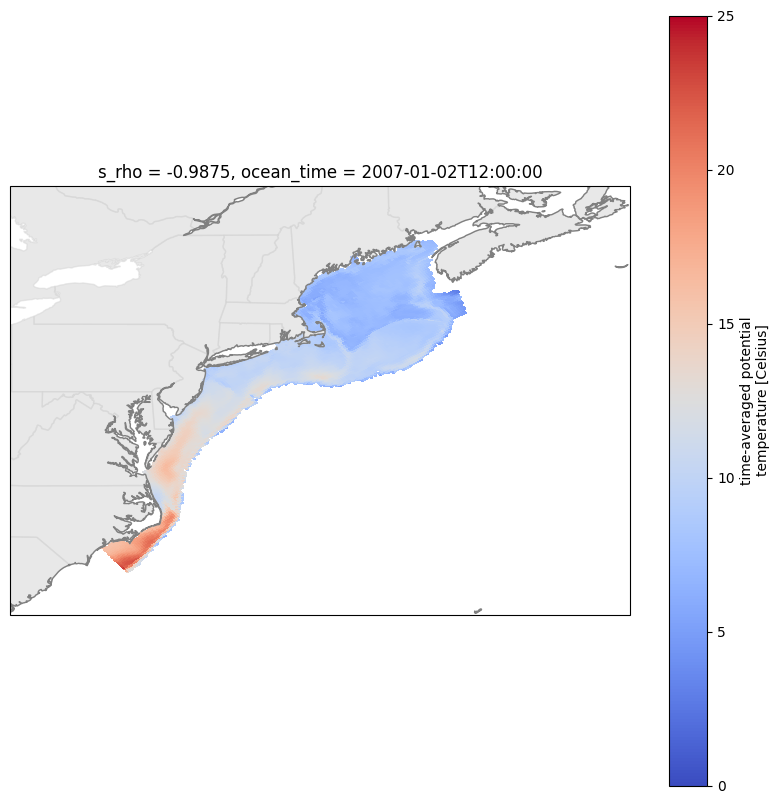

In [ ]:
## Check to make sure the mask worked 
fig,ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

doppio.temp.isel(ocean_time=0, s_rho=0).plot(x='lon_rho',y='lat_rho',cmap='coolwarm',vmin=0,vmax=25)
ax.add_feature(cfeature.STATES, color="lightgrey", alpha=0.5)
ax.add_feature(cfeature.COASTLINE,color='grey');